<a href="https://colab.research.google.com/github/MaartenCVonk/Causal-Modeling/blob/main/Application_IPW_sampling_to_obtain_ATE_in_back_door_case_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Summary**

This Notebook aims to calculate the causal effect of (binary) Treatment $T$ on outcome $Y$ with common observable confounder $Z$. We use Pearls axiomization for do-calculus to prove identifiability of outcome variable and use Dowhy to apply intervention to calculate the post intervention distribution $P(Y|do(T=t))$ using the inverse probabilty weighting algorithm (IPW).  

In [ ]:
!pip install dowhy &> /dev/nul
!pip install git+git://github.com/mkrphys/ipython-tikzmagic.git &> /dev/nul

In [ ]:
import dowhy
import seaborn as sns
import numpy as np
import pandas as pd
import dowhy.api
import matplotlib.pyplot as plt
%load_ext tikzmagic

## **Problem Setup:**


Suppose we have $N$ datapoints with covariates $Z$ where $Z$ is uniformly distributed between $[0,1]$: $z \sim U(0,1)$. Treatment $T$ has binomial distribution $t \sim B(1,\frac{1}{1+e^{-5z}})$. Also suppose we have outcome based on covariate $Z$ and treatment $T$: $y\sim 2z+t+0.1\mathcal{N}(0,1)$

In [ ]:
#The causal graph depicted this situation
#%%tikz
#\draw (0,0) rectangle (1,1);
#\filldraw (0.5,0.5) circle (.1);


![picture](https://drive.google.com/uc?export=view&id=1uuH89vkXM1hy9KlPooHVuni7XPUtAwTS)


In [ ]:
N = 5000

z = np.random.uniform(size=N)
t = np.random.binomial(1., p=1./(1. + np.exp(-5. * z)))
y = 2. * z + t + 0.1 * np.random.normal(size=N)

df = pd.DataFrame({'Z': z, 'T': t, 'Y': y})


Then the data looks like this:

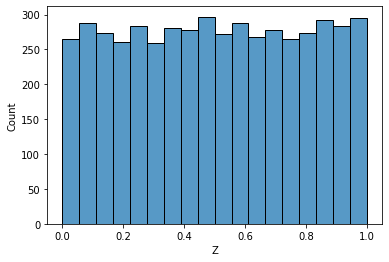

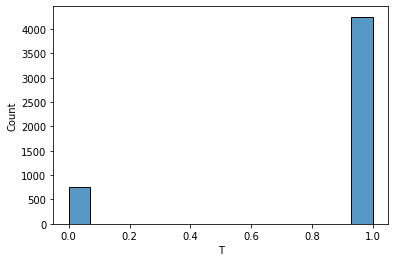

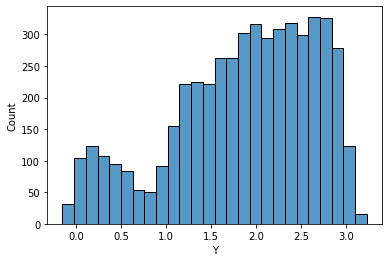

In [ ]:
sns.histplot(df['Z'])
plt.show()
sns.histplot(df['T'])
plt.show()
sns.histplot(df['Y'])
plt.show()

If we compare the outcomes based on Treatment without taking into account the covariates, we do it this naive way:

In [ ]:
#Naive effect of T on Y:
(df[df['T'] == 1].mean() - df[df['T'] == 0].mean())['Y']

## **Preliminaries and Identification**

This is not the causal effect, since $Z$ confounds the relation between $T$ and $Y$. We create a model that accounts for the intervention distribution $P(Y|do(T=t))$, but we first start with a complete axiomization of the do-calculus to account for the steps in the model created.

**Pearls Do-Calcus Rules:**

Let $G$ be the DAG associated with a causal model and let $P()$ be  the probability distribution induced by that model. For any disjoinst subsets of variables $X,Y,Z,W$ we have the following rules:

**Rule 1: $ $** 
$P(y|do(x),z,w) = P(y|do(x),w)$ if $((Y\perp \!\!\! \perp Z)|X,W)_{G_\overline{X}}$

**Rule 2: $ $** 
$P(y|do(x),do(z),w) = P(y|do(x),z,w)$ if $((Y\perp \!\!\! \perp Z)|X,W)_{G_{\overline{X}\underline{Z}}}$

**Rule 3: $ $** 
$P(y|do(x),do(z),w) = P(y|do(x),w)$ if $((Y\perp \!\!\! \perp Z)|X,W)_{G_{\overline{X}\overline{Z(W)}}}$

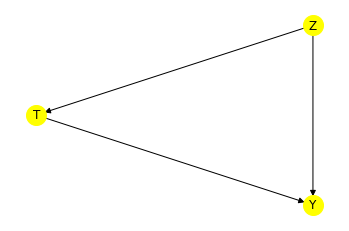

In [ ]:
#Create Causal Model:
from dowhy import CausalModel

causes = ['T']
outcomes = ['Y']
common_causes = ['Z']

model = CausalModel(df,
                    causes,
                    outcomes,
                    common_causes=common_causes)

# Let Dowhy plot the model just for verification purposes:
model.view_model(layout="dot")

We first want to know if we can identify $Y$ given cause $T$ and common cause $Z$. From *Causal Diagrams and the Identification of Causal Effects* (Pearl,200), we obtain the following theorem: 

**Theorem:**
A causal effect $q = P(y_1, … , y_k |do(t_1), … ,do(t_n))$ is identifiable in a model characterized
by a graph $G$ if there exists a finite sequence of transformations, each conforming to one
of the inference rules above, that reduces $q$ into a standard (i.e., “do-operator”-free)
probability expression involving observed quantities.

We can now prove that in our causal graph, $Y$ is identifiable by treatment $T$. First we marginalize out $z$ by rules of probability:
\begin{align}
P(Y|do(T=t))=\sum_{z}P(y|z,do(t))P(z|do(t))
\end{align}
Now we we observe that $((Y\perp \!\!\! \perp T)|Z)_{G_{\underline{T}}}$ and we apply the second rule of do-calculus to rewrite te first term:

\begin{align}
P(y|z,do(t))=P(y|z,t).
\end{align}

Similarly, we observe that  $(Z\perp \!\!\! \perp T)_{G_{\overline{T}}}$ to apply the third rule of do-calculus to obtain

\begin{align}
P(z|do(t))=P(z).
\end{align}

We can rewrite our first expression than to:
\begin{align}
P(Y|do(T=t))=\sum_{z}P(y|z,t)P(z).
\end{align}

Since the last expression is 'do-operator free', this is now an application of the do-calculus to prove identifiability. In this case the identifiablility is called the **back-door theorem.** Dowhy can also check identifiablity. We check if Dowhy is also able to identify the $Y$.

In [ ]:
# Check if the variable can be identified:
identification = model.identify_effect()
identification

## **From Identifiability to Estimation**

Note that we want to know 

$$
\begin{align} 
P(y|do(T=t))&=\sum_{z}P(y|t,z)P(z) =\sum_{z}\frac{P(y|t,z)P(t|z)P(z)}{P(t|z)} =\sum_{z}\frac{P(y,t,z)}{P(t|z)} 
\end{align} 
$$
where the first identity follows from the do-calculus as shown above. This means we can obtain the intervention distribution $P(y|do(T=t))$ by 
accounting for the propensity score $P(t|z)$. So now we need to train a model $\hat(e)$ to predict $T$ from $Z$. This is done by logistic regresion. We apply this models to obtain weights for each data point: $w_i = \frac{1}{P(T_i=t|z_i)}$. 

In [ ]:
from dowhy.do_samplers.weighting_sampler import WeightingSampler
sampler = WeightingSampler(df,
                           causal_model=model,
                           keep_original_treatment=True,
                           variable_types={'T': 'b', 'Z': 'c', 'Y': 'c'})

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Using this weights we will now sample from the intervention distribution $P(y|do(T=t))$ by sampling from our data given the weights we created to adjust for the covariate $Z$. Data points with higher weights $w_i$ are more likely to get picked from the data than datapoints with lower weights. Note that there will be duplicates in our new data when we create datasamples of equal length to the original data. Since we had more observations of $T=1$ in our original dataset, observations of $T=0$ received higher weights and therefore the new dataset will be balanced. 

In [ ]:
interventional_df = sampler.do_sample(None)

By doing this we obtain a new causal graph where the arrow from $Z$ to $T$ is eliminated:

![picture](https://drive.google.com/uc?export=view&id=1bIA80lmriftvZ9i1jiuv83-1dpHhXtb7)



In [ ]:
#Instead of creating first creating the sampler and then the dataset, we can also apply the do-sampler directly. This yields the same results.
interventional_df = df.causal.do('T', 
                          method='weighting', 
                          variable_types={'T': 'b', 
                                          'Z': 'c', 
                                          'Y': 'c'},
                          outcome='Y',
                          common_causes=['Z'])

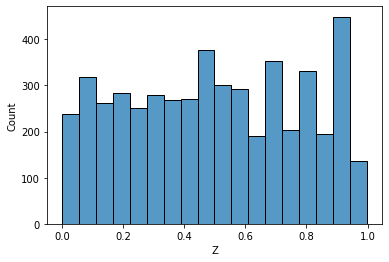

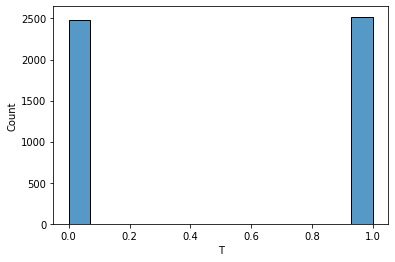

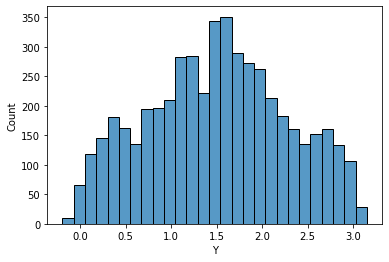

In [ ]:
# We can take a new look at the distribution of the data:
sns.histplot(interventional_df['Z'])
plt.show()
sns.histplot(interventional_df['T'])
plt.show()
sns.histplot(interventional_df['Y'])
plt.show()

Now given the causal relation is not confounded anymore, we can calculate the causal effect. Note for the expectation first that 
\begin{align*}
\mathbb{E}(Y\mid do(T))&=\sum_{y} \sum_{z}\frac{YP(y,t,z)}{P(t|z)} =\sum_{y} \sum_{z}\frac{yP(y)1_{T=t, Z=z}}{P(t|z)} \\ &=\mathbb{E}(\sum_{z}\frac{Y1_{T=t,Z=z}}{P(t|z)})
=\mathbb{E}(\frac{Y1_{T=t}}{P(t|Z)}).
\end{align*}


So we we implement that to calculate the causal effect we have 

\begin{align*}
\mathbb{E}(Y\mid do(T=1))-\mathbb{E}(Y\mid do(T=0)) = \mathbb{E}(\frac{Y1_{T=1}}{P(t|Z)})-\mathbb{E}(\frac{Y1_{T=0}}{1-P(t|Z)})
\end{align*}

We can then estimate the causal effect by the following estimand:
\begin{align*}
\hat{\tau} = \frac{1}{n}\sum_{i}(\frac{y_i1_{T=1}}{\hat{e}(z_i)}-\frac{y_i1_{T=0}}{1-\hat{e}(z_i)})
\end{align*}
where $\hat{e}$ is the model used to estimate $P(t|Z)$. Since we have already applied that estimate in our python function, this reduces to 

\begin{align*}
\hat{\tau} =\frac{1}{n}\sum_{i}(y_i1_{T=1}-y_i1_{T=0}).
\end{align*}

In [ ]:
(interventional_df[interventional_df['T'] == 1].mean() - interventional_df[interventional_df['T'] == 0].mean())['Y']